In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: klaus2twarz2
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:14<00:00, 154MB/s]


In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import librosa # biblioteka do analizy dźwięku i muzyki w Pythonie
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize # służy do przetwarzania i analizy obrazów w Pythonie.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


wczytanie danych

In [ ]:
data_df = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")
print(data_df.head())
print(data_df.shape)
print(data_df["Class"].unique())
print(len(data_df["Class"].unique()))

#poprawka ścieżki

data_df['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset' + data_df['FilePath'].str[1:]
print(data_df.head())

                                        FilePath               Class
0  ./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav  Mohammed_Aluhaidan
1  ./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav  Mohammed_Aluhaidan
2  ./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav  Mohammed_Aluhaidan
3  ./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav  Mohammed_Aluhaidan
4  ./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav  Mohammed_Aluhaidan
(6687, 2)
['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']
12
                                            FilePath               Class
0  /content/quran-recitations-for-audio-classific...  Mohammed_Aluhaidan
1  /content/quran-recitations-for-audio-classific...  Mohammed_Aluhaidan
2  /content/quran-recitations-for-audio-classific...  Mohammed_Aluhaidan
3  /content/quran-recitations-for-audio-classific

In [ ]:
data_df['FilePath'].iloc[2]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

In [ ]:
print("Data Shape: ", data_df.shape)
print("Class Distribution: ", data_df['Class'].value_counts())

Data Shape:  (6687, 2)
Class Distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


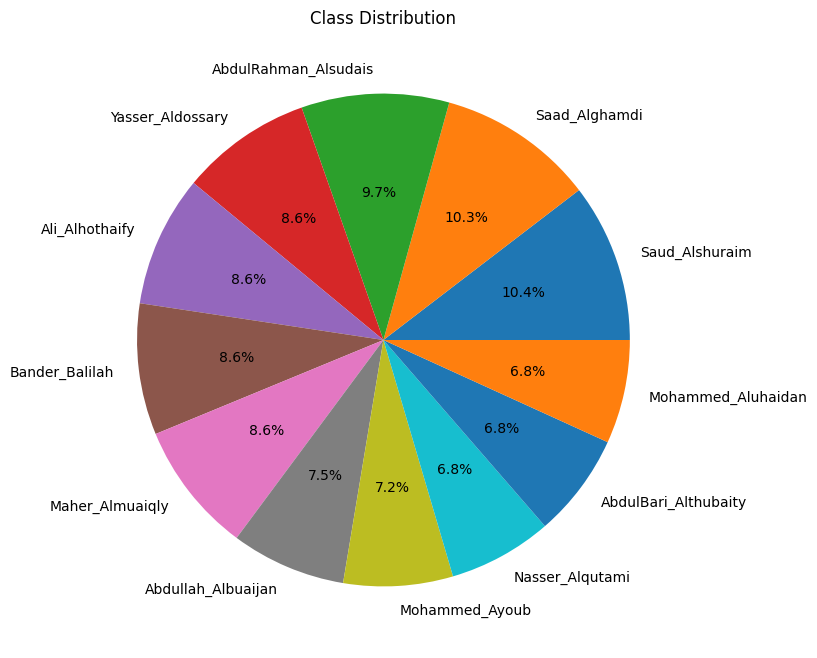

In [ ]:
plt.figure(figsize = (8,8))
x = data_df['Class'].value_counts()
y = data_df['Class'].value_counts().index
plt.pie(x, labels = y, autopct = '%1.1f%%')
plt.title('Class Distribution')
plt.show()

dzielenie danych na train, test i val oraz label encoder etykety na liczby

In [ ]:
label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index).sample(frac=0.5, random_state=42)
val = data_df.drop(train.index).drop(test.index)

print(train.shape)
print(test.shape)
print(val.shape)

(4681, 2)
(1003, 2)
(1003, 2)


label encoder i Dataset

In [ ]:


class CustomAudioDataset(Dataset):
  def __init__(self, data_frame):
    self.data_frame = data_frame
    self.labels = torch.Tensor(list(data_frame["Class"])).type(torch.LongTensor).to(device)
    # Zamiana etykiet tekstowych na liczby, konwersja na tensor typu long i przeniesienie na GPU/CPU
                                         # tworzy tensor z poniższych danych                       @@@@ torch.Tensor
                                            # zamienia etykiety tekstowe na liczby (np. "cat" → 0) @@@@ label_encoder.fit_transform
                                              # konwertuje tensor na typ całkowity (int64)         @@@@ torch.LongTensor
                                                 # przenosi tensor na urządzenie (CPU lub GPU)

    self.audios = [torch.Tensor(self.get_spectogram(path)).type(torch.FloatTensor) for path in data_frame["FilePath"]]
    # Dla każdego pliku audio generuje spektrogram, zamienia go na tensor typu float i zapisuje na liście
                                            # generuje spektrogram z pliku i tworzy z niego tensor @@@@ torch.Tensor(self.get_spectogram(path))
                                                                # konwertuje tensor na typ float32 @@@@ .type(torch.FloatTensor)
                                                   # dla każdej ścieżki do pliku audio w DataFrame @@@@ for path in data_frame["FilePath"]

                                                   #spectogram: To macierz, która pokazuje: oś X – czas, oś Y – częstotliwość, wartość – energia / natężenie dźwięku w danej częstotliwości i czasie.
  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    img_path = self.data_frame.iloc[idx, 0]
    label = torch.Tensor(self.labels[idx]).to(device)
    audio = self.audios[idx].unsqueeze(0).to(device)
    return audio, label

  def get_spectogram(self, file_path):
    sr = 22050              # Częstotliwość próbkowania (samples per second)
    duration = 5            # Czas trwania przetwarzanego dźwięku w sekundach

    img_height = 128        # Wysokość obrazu spektrogramu (liczba pasm częstotliwości)
    img_width = 256         # Szerokość obrazu spektrogramu (liczba próbek w czasie)

    # Wczytanie pliku audio z podaną częstotliwością próbkowania i ucięcie/trwanie do 5 sekund
    signal, sr = librosa.load(file_path, sr=sr, duration=duration)


    # Generuje mel-spektrogram – dwuwymiarową macierz, która pokazuje energię dźwięku
    # w czasie (oś X) i na skali częstotliwości mel (oś Y)
    spec = librosa.feature.melspectrogram(
      y=signal,          # sygnał audio (tablica próbek)
      sr=sr,             # częstotliwość próbkowania sygnału
      n_fft=2048,        # rozmiar okna FFT (ilość próbek analizowanych naraz)
      hop_length=512,    # przesunięcie okna FFT między kolejnymi analizami (w próbkach)
      n_mels=128         # liczba pasm mel (wysokość spektrogramu)
    )

    # Konwersja mel-spektrogramu mocy na skalę decybelową (logarytmiczną)
    spec_db = librosa.power_to_db(spec, ref=np.max) # ref=np.max oznacza, że wartości są normalizowane względem maksymalnej wartości w spektrogramie,
                                                    # co poprawia czytelność i stabilność reprezentacji dźwięku dla modelu

    # Dopasowuje długość spektrogramu (liczbę ramek czasowych) do oczekiwanego rozmiaru
    spec_resized = librosa.util.fix_length(spec_db, size = (duration*sr) // 512+1) # size obliczone na podstawie długości dźwięku (duration), częstotliwości próbkowania (sr)
                                                                                   # i kroku przesunięcia (hop_length = 512), +1 dla bezpieczeństwa

    # Zmienia rozmiar spektrogramu do stałych wymiarów (img_height x img_width)
    # anti_aliasing=True minimalizuje zniekształcenia podczas skalowania obrazu
    spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)

    return spec_resized


In [ ]:
train_dataset = CustomAudioDataset(train)
test_dataset = CustomAudioDataset(test)
val_dataset = CustomAudioDataset(val)

paramtry modelu

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25

DATALOADER

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

MODEL

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size= 3, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, kernel_size= 3, padding = 1)

    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear((64*16*32), 4096)
    self.linear2 = nn.Linear(4096, 1024)
    self.linear3 = nn.Linear(1024, 512)
    self.output = nn.Linear(512, len(data_df["Class"].unique()))

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):

    x = self.conv1(x) # -> Outputs: (16, (128, 256))
    x = self.pooling(x)# -> Outputs: (16, (64, 128))
    x = self.relu(x)
    #x = self.dropout(x)

    x = self.conv2(x) # -> Outputs: (32, (64, 128))
    x = self.pooling(x) # -> Outputs: (32, (32, 64))
    x = self.relu(x)
    #x = self.dropout(x)

    x = self.conv3(x) # -> Outputs: (64, (32, 64))
    x = self.pooling(x) # -> Outputs: (64, (16, 32))
    x = self.relu(x)
    #x = self.dropout(x)

    x = x.view(x.size(0), -1)

    x = self.flatten(x)

    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)


    x = self.linear3(x)
    x = self.dropout(x)

    x = self.output(x)

    return x




In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
              ReLU-3          [-1, 16, 64, 128]               0
            Conv2d-4          [-1, 32, 64, 128]           4,640
         MaxPool2d-5           [-1, 32, 32, 64]               0
              ReLU-6           [-1, 32, 32, 64]               0
            Conv2d-7           [-1, 64, 32, 64]          18,496
         MaxPool2d-8           [-1, 64, 16, 32]               0
              ReLU-9           [-1, 64, 16, 32]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                 [-1, 4096]     134,221,824
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 1024]       4,195,328
          Dropout-14                 [-

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = [] #strata
total_loss_val_plot = []
total_acc_train_plot = [] #dokładność
total_acc_val_plot = []

# Główna pętla treningowa – iteracja po epokach
for epoch in range(EPOCHS):
  # Zerowanie sumatorów dla danej epoki
  total_loss_train = 0.0
  total_acc_train = 0.0
  total_loss_val = 0.0
  total_acc_val = 0.0

  # Pętla po batchach treningowych
  for inputs, labels in train_loader:
    optimizer.zero_grad()  # Zerowanie gradientów przed każdą aktualizacją

    outputs = model(inputs)  # Przekazanie danych przez model (forward pass)

    train_loss = criterion(outputs, labels)  # Obliczenie straty
    total_loss_train += train_loss.item()    # Dodanie wartości straty (float) do sumy

    train_loss.backward()  # Propagacja wsteczna – obliczenie gradientów

    # Obliczenie liczby poprawnie sklasyfikowanych próbek
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()  # Aktualizacja wag modelu na podstawie gradientów

  # Walidacja (bez aktualizacji wag)
  with torch.no_grad():  # Wyłączenie autograd – oszczędność pamięci i czasu
    for inputs, labels in val_loader:
      outputs = model(inputs)  # Forward pass na zbiorze walidacyjnym

      val_loss = criterion(outputs, labels)  # Strata walidacyjna
      total_loss_val += val_loss.item()

      # Obliczenie dokładności walidacyjnej
      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

    #rysowanie wykresów normalizacja ogromnych liczb przez 1000

  fin_total_loss_train = round(total_loss_train /1000, 4)
  fin_total_loss_val = round(total_loss_val /1000, 4)
  fin_total_acc_train = round(total_acc_train /train_dataset.__len__() * 100, 4)
  fin_total_acc_val = round(total_acc_val /val_dataset.__len__() * 100, 4)


  total_loss_train_plot.append(fin_total_loss_train)
  total_loss_val_plot.append(fin_total_loss_val)
  total_acc_train_plot.append(fin_total_acc_train)
  total_acc_val_plot.append(fin_total_acc_val)

  print(f'''Epoch no. {epoch + 1}/{EPOCHS} Train Loss: {fin_total_loss_train} Train Accuracy: {fin_total_acc_train} Validation Loss: {fin_total_loss_val} Validation Accuracy: {fin_total_acc_val}''')
  print("="*30)

Epoch no. 1/25 Train Loss: 0.6639 Train Accuracy: 41.5937 Validation Loss: 0.045 Validation Accuracy: 78.4646
Epoch no. 2/25 Train Loss: 0.1424 Train Accuracy: 85.3023 Validation Loss: 0.0227 Validation Accuracy: 87.9362
Epoch no. 3/25 Train Loss: 0.063 Train Accuracy: 93.7834 Validation Loss: 0.0178 Validation Accuracy: 92.4227
Epoch no. 4/25 Train Loss: 0.0409 Train Accuracy: 95.8556 Validation Loss: 0.0139 Validation Accuracy: 94.0179
Epoch no. 5/25 Train Loss: 0.0346 Train Accuracy: 96.5819 Validation Loss: 0.011 Validation Accuracy: 95.3141
Epoch no. 6/25 Train Loss: 0.0305 Train Accuracy: 97.0305 Validation Loss: 0.0131 Validation Accuracy: 94.7159
Epoch no. 7/25 Train Loss: 0.0233 Train Accuracy: 97.7569 Validation Loss: 0.0249 Validation Accuracy: 92.7218
Epoch no. 8/25 Train Loss: 0.0188 Train Accuracy: 98.1628 Validation Loss: 0.011 Validation Accuracy: 95.5135
Epoch no. 9/25 Train Loss: 0.0308 Train Accuracy: 97.2869 Validation Loss: 0.0194 Validation Accuracy: 91.7248
Epoch

test modelu

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    pred = model(inputs)

    acc = (torch.argmax(pred, axis=1) == labels).sum().item()
    total_acc_test += acc

    loss = criterion(pred, labels)
    total_loss_test += loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 95.7129 and Loss is 0.0175


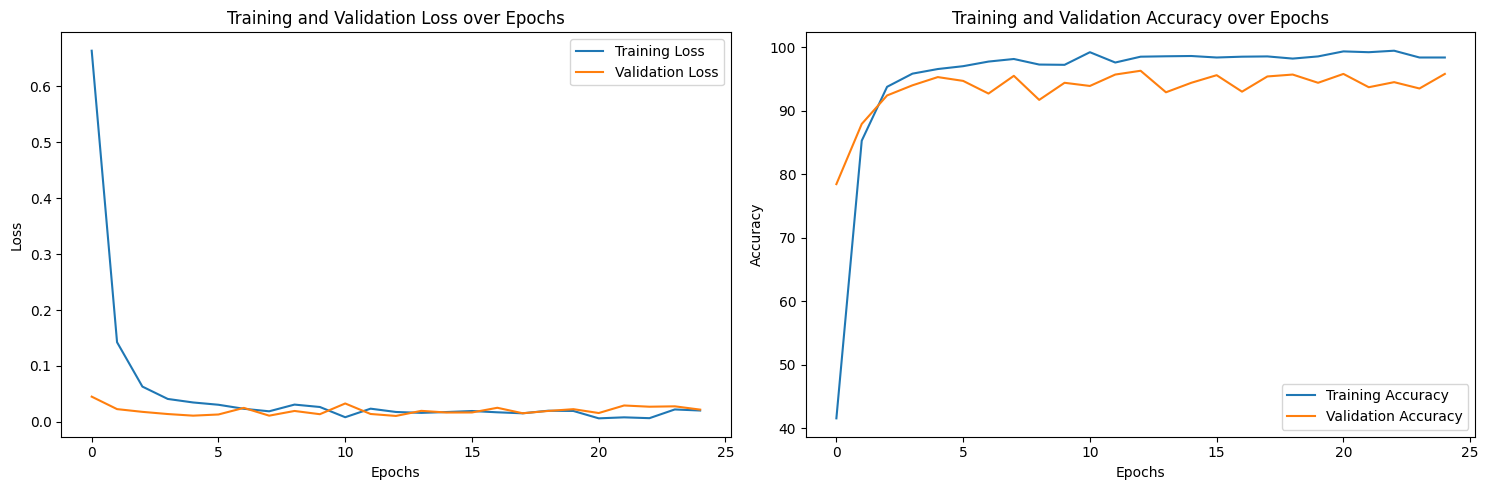

In [ ]:
ig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
#axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
#axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()